In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import functions as f
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

/home/hatice/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/hatice/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# better visualization of numbers
pd.options.display.float_format = '{:,.2f}'.format 

# Diary

- I tried different methods to fill missing values such as linear regression and knnImputer. Because the initial idea was comparing different model accuracy then select the best one. But as i have a lot of categorical data which is difficult and no sense to transform into numerical values I discarded these ideas. Then i filled missing values using random forest reressor. 

- Calculated prticipation of women and men to olympic games and their  success. -> it is not a good idea to compare two genders, bc they don't compate in the same area, there are women games  and men games. 

- I tried to show how are the distribution of gender over year too participate to olypic games, plotted 10 team and 10 athlete with most medals. 




## IDEAS

TO DO for dataset exploration: 
1. compare male and female athlets participation to the games each year
2. correlation between age, sex, height and weight.
3. distribution of medals per age and per sex
4. Check if medals are distribuited correctly, in sense of: if there are years that have more medal than the maximum they can have. For this study the olympics description on kaggle. 
5. LOOK IF IT MAKES SENSE TO ASSOCIATE AN ID TO EACH COUNTRY IN *noc_region.csv* DATASET AND USE IT FOR ANALYSING THE SUCCESS OF THEM?
6. Should I transform float data in int? not all of them, like medals etc ?

# DATA EXPLORATION AND DATA WRANGLING

In [3]:
olympic_df = pd.read_csv('dataset_olympic_data/dataset_olympics.csv')
noc_region_df = pd.read_csv('dataset_olympic_data/noc_region.csv')

## EXPLORING THE DATASET

In [4]:
# noc_region_df

In [5]:
# noc_region_df['notes'].unique()


In [6]:
# noc_region_df[noc_region_df['notes'] == 'Newfoundland']

In [7]:
# olympic_df.head()

In [8]:
# olympic_df.info()

In [9]:
# olympic_df.describe()

In [10]:
# olympic_df.isna().sum()

In [11]:
# olympic_df['Medal'].unique()

In [12]:
medal_mask = ['Gold', 'Silver', 'Bronze']
olympic_df['Medal'].value_counts()[medal_mask] 

Medal
Gold      3292
Silver    3190
Bronze    3208
Name: count, dtype: int64

### Histogram

From the histogram below we can see that:

- The majority of the athletes age is between ~18 and ~25
- Most athletes are between 160cm and 190cm 
- Most athletes weigh between 50 and 100 and the peak is  around 175
- Participation to the olympic games has increased over time. 

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Height'}>],
       [<AxesSubplot:title={'center':'Weight'}>,
        <AxesSubplot:title={'center':'Year'}>]], dtype=object)

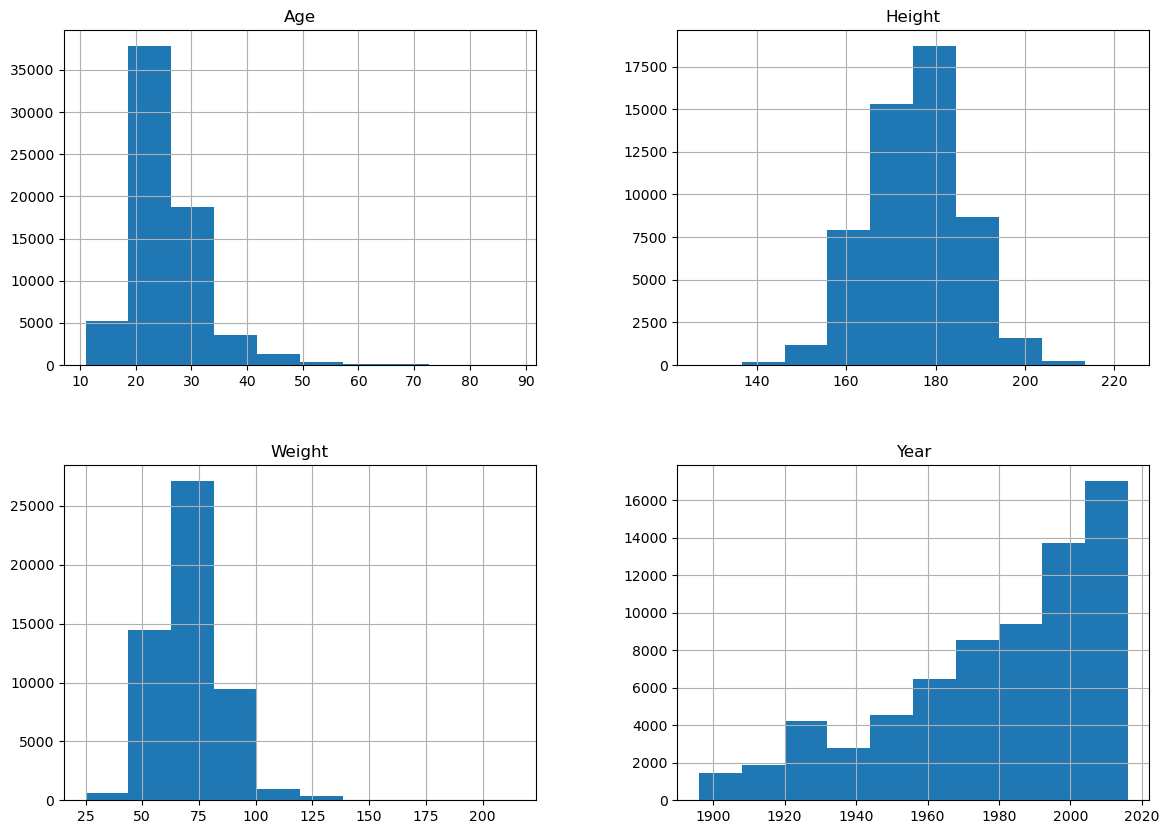

In [13]:
olympic_df.drop(columns='ID').hist(figsize=(14,10))

### PARTICIPATION OF MALE AND FEMALE  ATHLETES  IN THE OLYMPIC GAMES OVER THE YEARS 

It is evident that women's involvement was minimal before the 1970s, with a significant increase starting in the 1980s. The data shows that while male athletes consistently had higher participation rates, the gap between male and female athletes has been narrowing steadily in recent decades.

The second graph shows the number of medals won by male and female athletes over the years. It is evident that men consistently won more medals than women until around the 1960s. From this point onwards, the gap between the number of medals won by men and women began to decrease.

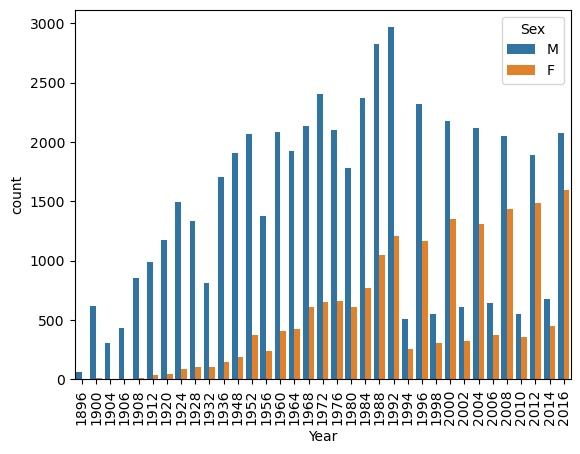

In [27]:
sns.countplot(olympic_df, x="Year", hue='Sex')
plt.xticks(rotation = 90)
plt.show()

In [285]:
medals_by_year_sex = olympic_df.groupby(['Year', 'Sex']).size().unstack(fill_value=0).reset_index()

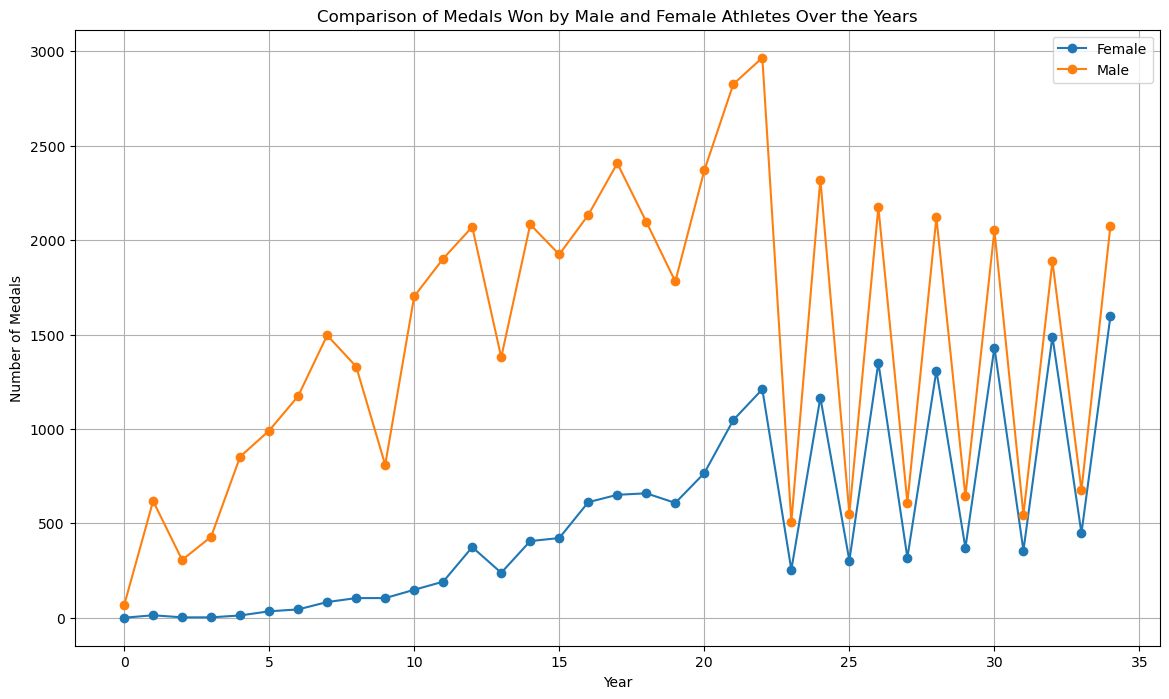

In [286]:
plt.figure(figsize=(14, 8))
plt.plot(medals_by_year_sex.index.values, medals_by_year_sex['F'].values, marker='o', label='Female')
plt.plot(medals_by_year_sex.index.values, medals_by_year_sex['M'].values, marker='o', label='Male')

plt.title('Comparison of Medals Won by Male and Female Athletes Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Medals')
plt.legend()
plt.grid(True)
plt.show()

### Distribution of the medals over gender and age

We see that in total men got more medals then women, is due to high quantity of men participation to the olympic games. 

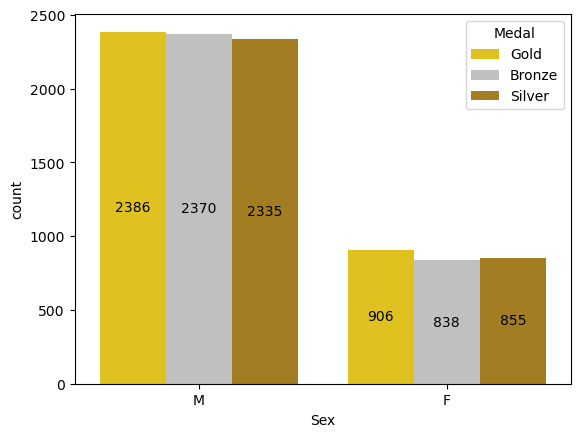

In [259]:
colors = ['gold', 'silver', 'darkgoldenrod']

ax = sns.countplot(olympic_df, x="Sex", hue='Medal', palette=colors)
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, fontsize=10)

plt.show()

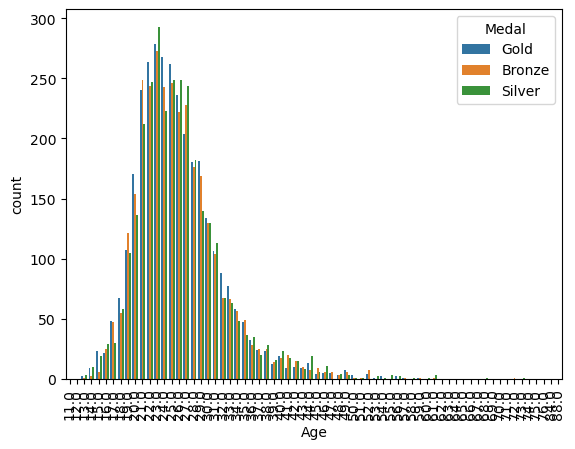

In [298]:
sns.countplot(olympic_df, x="Age", hue='Medal')
plt.xticks(rotation=90)
plt.show()

### Total medals gained by each team and visualization of top 10 team with most medals

**CALCULATE ALSO PERCENTAGE OVER NUMBER OF ATHLETES**

In [88]:
medal_count = olympic_df.groupby(['Team','Medal']).size().unstack(fill_value=0).reset_index()
medal_count['Total'] = medal_count[['Gold', 'Silver', 'Bronze']].sum(axis=1)

In [89]:
medal_count

Medal,Team,Bronze,Gold,Silver,Total
0,A North American Team,3,0,0,3
1,Algeria,2,1,1,4
2,Ali-Baba II,1,0,0,1
3,Amateur Athletic Association,0,1,0,1
4,Amstel Amsterdam,2,0,0,2
...,...,...,...,...,...
351,Widgeon,1,0,0,1
352,Willem-Six,1,0,0,1
353,Winnipeg Shamrocks-1,0,7,0,7
354,Yugoslavia,21,31,39,91


In [90]:
ten_team_with_most_medals = medal_count.sort_values(by=['Total'], ascending=False).head(10)

In [91]:
ten_team_with_most_medals


Medal,Team,Bronze,Gold,Silver,Total
329,United States,336,709,415,1460
106,France,221,167,183,571
155,Italy,186,202,183,571
284,Soviet Union,147,212,145,504
123,Great Britain,163,154,164,481
118,Germany,128,133,135,396
14,Australia,149,97,124,370
292,Sweden,140,79,122,341
49,Canada,114,107,107,328
217,Netherlands,109,58,90,257


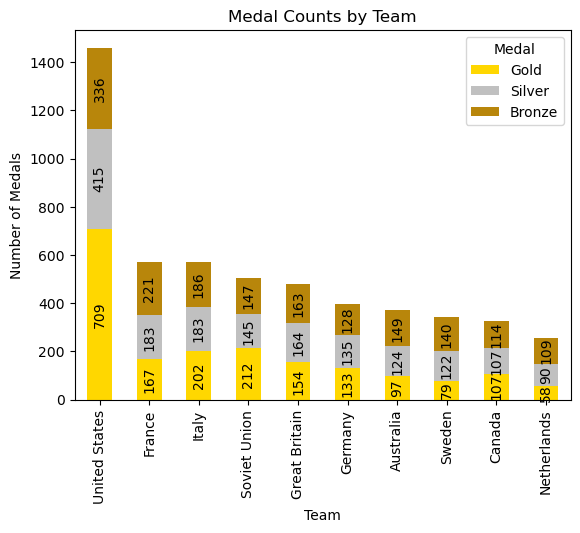

In [108]:
colors = ['gold', 'silver', 'darkgoldenrod']

ax = ten_team_with_most_medals.set_index('Team')[['Gold', 'Silver', 'Bronze']].plot(kind='bar', stacked=True, color=colors)

ax.set_title('Medal Counts by Team')
ax.set_xlabel('Team')
ax.set_ylabel('Number of Medals')

# number of medals for each type on labels
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=90, fontsize=10)

plt.show()

### Visualization of 10 athlete with most medals

**THEN CALCULATE PERCENTAGE OVER PARTICIPATION**

In [206]:
athlete_medal_count = olympic_df.groupby(['ID','Medal']).size().unstack(fill_value=0)
athlete_medal_count['Total'] = athlete_medal_count[['Gold', 'Silver', 'Bronze']].sum(axis=1)
athlete_medal_count = athlete_medal_count.reset_index()
athlete_medal_count = athlete_medal_count[['ID','Gold', 'Silver', 'Bronze', 'Total']]
athlete_medal_count.columns.name = None

In [207]:
ten_athlete_with_most_medals = athlete_medal_count.sort_values(by='Total', ascending=False).head(10)

In [208]:
ten_athlete_with_most_medals

,ID,Gold,Silver,Bronze,Total
664,4198,7,5,3,15
2194,11951,8,4,1,13
6951,35550,8,4,0,12
4492,23426,3,4,5,12
4089,21402,7,3,1,11
3662,18826,7,4,0,11
2128,11642,8,2,1,11
6565,33557,10,0,0,10
2191,11943,6,3,1,10
5564,28790,3,6,1,10


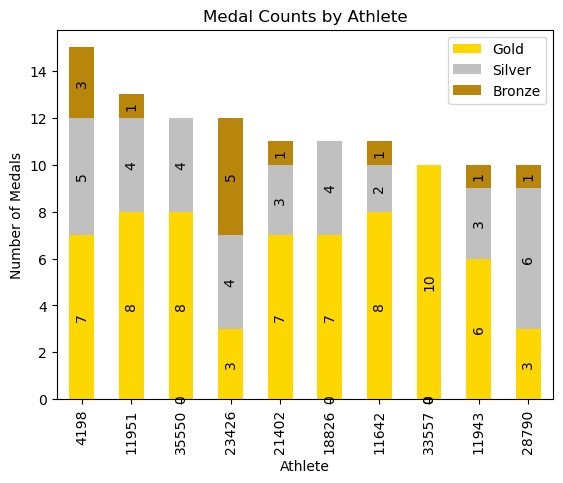

In [209]:
colors = ['gold', 'silver', 'darkgoldenrod']

ax = ten_athlete_with_most_medals.set_index('ID')[['Gold', 'Silver', 'Bronze']].plot(kind='bar', stacked=True, color=colors)

ax.set_title('Medal Counts by Athlete')
ax.set_xlabel('Athlete')
ax.set_ylabel('Number of Medals')

# number of medals for each type on labels
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=90, fontsize=10)

plt.show()

### CORRELATIN MATRIX

<AxesSubplot:>

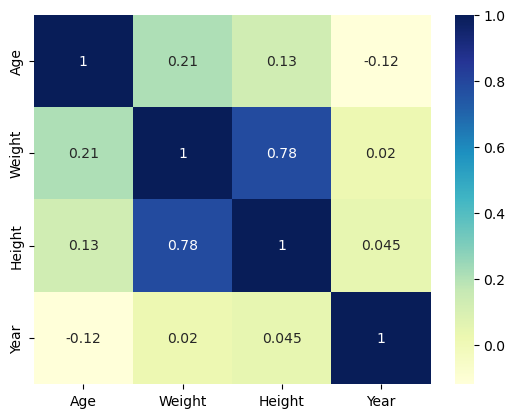

In [266]:
corr_df = olympic_df[['Age', 'Weight', 'Height', 'Year']]
corr_df.corr()
sns.heatmap(corr_df.corr(), cmap="YlGnBu", annot=True)

## Data Cleaning

COLUMNS CAN BE TRANSFORM:
- SEX: M/F -> 0/1
- MEDAL: NaN, Bronze, Silver, Gold -> 0, 1, 2, 3

I can use two methods to encode the labels:
1. LabelEncoder from sklearn library
2. Doing it by hand

As I have just few labels to encode, I prefer to use second method because LabelEncoder assign numbers starting from 0 and so on and in my case is not preferable a generic assignment because of the different priorty/importance of the medal types. Instead for Sex encoding it can be used LabelEncoding but for code clearity I will use one method for all my features that I want to encode.

In [98]:
olympic_df['Medal'].unique()

array([nan, 'Gold', 'Bronze', 'Silver'], dtype=object)

In [99]:
# label_encoder = preprocessing.LabelEncoder() 
# olympic_df['Sex']= label_encoder.fit_transform(olympic_df['Sex']) 

In [100]:
olympic_df_medals = olympic_df.copy()
olympic_df_medals['Medal'].unique()

array([nan, 'Gold', 'Bronze', 'Silver'], dtype=object)

In [77]:
replace_sex={
    'M':0,
    "F":1
}
olympic_df['Sex'] = olympic_df['Sex'].replace(replace_sex)


replace_medal={
    "Bronze":1,
    "Silver":2,
    "Gold":3
}
olympic_df['Medal'] = olympic_df['Medal'].replace(replace_medal)

pd.set_option("future.no_silent_downcasting", True)

In [78]:
olympic_df_medals['Medal'].unique()

array([nan, 'Gold', 'Bronze', 'Silver'], dtype=object)

### Check duplicated

In [17]:
olympic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      70000 non-null  int64  
 1   Name    70000 non-null  object 
 2   Sex     70000 non-null  int64  
 3   Age     67268 non-null  float64
 4   Height  53746 non-null  float64
 5   Weight  52899 non-null  float64
 6   Team    70000 non-null  object 
 7   NOC     70000 non-null  object 
 8   Games   70000 non-null  object 
 9   Year    70000 non-null  int64  
 10  Season  70000 non-null  object 
 11  City    70000 non-null  object 
 12  Sport   70000 non-null  object 
 13  Event   70000 non-null  object 
 14  Medal   9690 non-null   float64
dtypes: float64(4), int64(3), object(8)
memory usage: 8.0+ MB


In [18]:
print('There are {} duplicate rows in olympic_df based on all columns.'.format(olympic_df.duplicated().sum()))


There are 383 duplicate rows in olympic_df based on all columns.


In [19]:
olympic_df.drop_duplicates(keep='first', inplace=True)

In [20]:
print('There are {} duplicate rows in olympic_df based on all columns.'.format(olympic_df.duplicated().sum()))


There are 0 duplicate rows in olympic_df based on all columns.


In [21]:
# olympic_df.info()

### Missing values

#### Percentage of missing data:

In [22]:
# missing_percentage = ((olympic_df.isnull().sum())/len(olympic_df))*100
# missing_data = pd.DataFrame({'Missing Values': olympic_df.isnull().sum(), 'Percentage': missing_percentage})
# print(missing_data)

#### Medal column cleaning

Filling missing values in Medal column with fillna(), because actually they are not missing values where we have NaN, but it indicates that the athlet didn't get any medal

In [23]:
olympic_df['Medal'] = olympic_df['Medal'].fillna(value=0)

In [24]:
# olympic_df.head()

In [267]:
olympic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   ID      70000 non-null  int64   
 1   Name    70000 non-null  object  
 2   Sex     70000 non-null  object  
 3   Age     67268 non-null  float64 
 4   Height  53746 non-null  float64 
 5   Weight  52899 non-null  float64 
 6   Team    70000 non-null  object  
 7   NOC     70000 non-null  object  
 8   Games   70000 non-null  object  
 9   Year    70000 non-null  int64   
 10  Season  70000 non-null  object  
 11  City    70000 non-null  object  
 12  Sport   70000 non-null  object  
 13  Event   70000 non-null  object  
 14  Medal   9690 non-null   object  
 15  AgeBin  67268 non-null  category
dtypes: category(1), float64(3), int64(2), object(10)
memory usage: 8.1+ MB


In [25]:
olympic_df.isna().sum()

ID            0
Name          0
Sex           0
Age        2671
Height    15876
Weight    16718
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal         0
dtype: int64

In [26]:
olympic_df["Medal"].unique()

array([0., 3., 1., 2.])

#### Random Forest

Filling missing values using random forest regressor

In [27]:
for column in olympic_df.columns:
    if olympic_df[column].isna().any():
        olympic_df = f.impute_missing_values_with_random_forest(olympic_df, column)

In [28]:
# olympic_df.info()

## Plots

As I notice that looking in a  certain timeline i see that there  are not complete information i rtied to print for golf games before 1900, and we can see that there are not information about who was in second place or third. In the dataset there are collected only few information for each sport/year/athlete/etc..

In [29]:
olympic_df[(olympic_df['Year']<=1900) & (olympic_df['Sport']=='Golf')]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
283,150,Margaret Ives Abbott (-Dunne),1,23.00,164.04,69.60,United States,USA,1900 Summer,1900,Summer,Paris,Golf,Golf Women's Individual,3.00
284,151,Mary Perkins Ives Abbott (Perkins-),1,42.00,164.32,70.48,United States,USA,1900 Summer,1900,Summer,Paris,Golf,Golf Women's Individual,0.00
30535,15740,A. Brun,1,33.54,160.68,61.02,France,FRA,1900 Summer,1900,Summer,Paris,Golf,Golf Women's Individual,0.00
49528,25513,John Hubert Edward Daunt,0,34.00,174.75,85.42,Great Britain,GBR,1900 Summer,1900,Summer,Paris,Golf,Golf Men's Individual,0.00
54149,27778,Pierre Emile Deschamps,0,27.29,177.22,84.69,France,FRA,1900 Summer,1900,Summer,Paris,Golf,Golf Men's Individual,0.00
58116,29749,William Bathurst Dove,0,28.00,185.24,87.55,Great Britain,GBR,1900 Summer,1900,Summer,Paris,Golf,Golf Men's Individual,0.00
66032,33784,Lucile Virginie Madeleine Fain (Condren-),1,32.00,165.69,58.66,France,FRA,1900 Summer,1900,Summer,Paris,Golf,Golf Women's Individual,0.00


From the histogram below we can see that:

- Men participated more than women to olympic games
- The majority of the athletes age is between ~18 and ~25
- Most athletes are between 160cm and 190cm 
- Most athletes weigh between 50 and 100 and the peak is  around 175
- Participation to the olympic games has increased over time. 
- Due to high participation most of athletes didn't win medals 

array([[<AxesSubplot:title={'center':'Sex'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'Height'}>,
        <AxesSubplot:title={'center':'Weight'}>],
       [<AxesSubplot:title={'center':'Year'}>,
        <AxesSubplot:title={'center':'Medal'}>]], dtype=object)

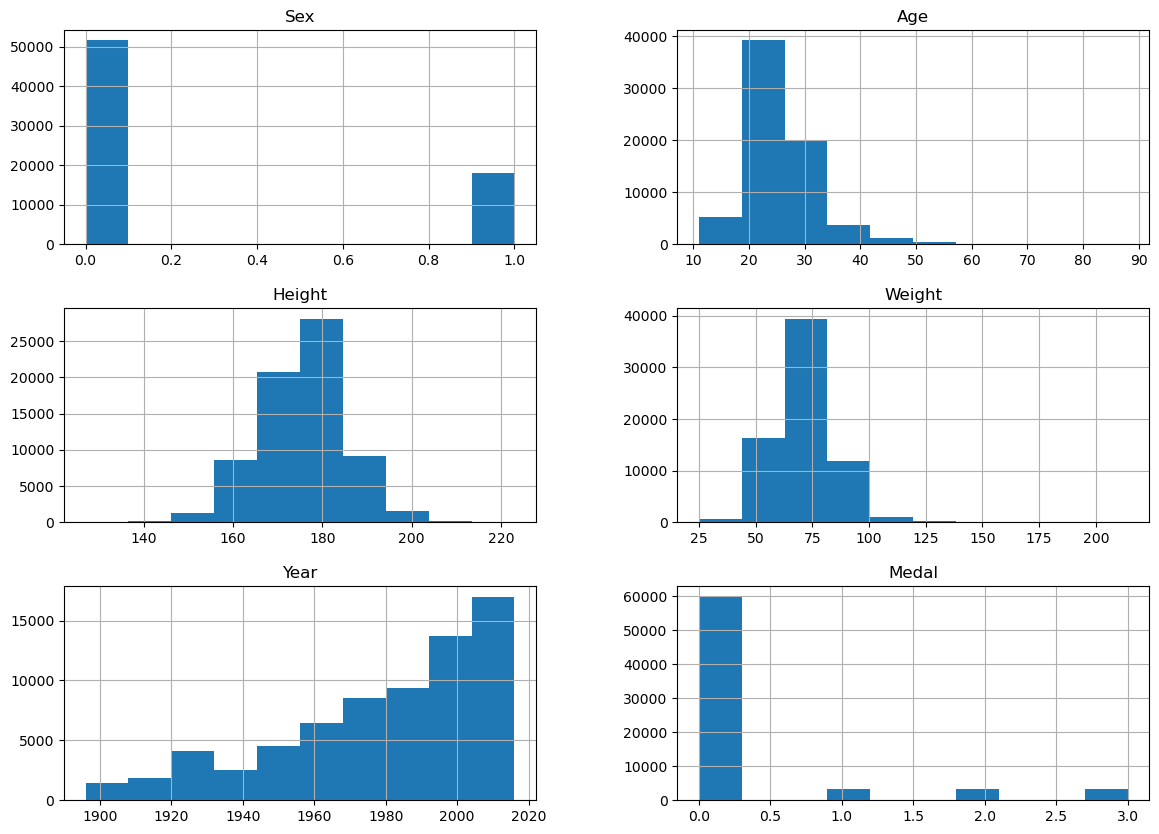

In [30]:
olympic_df.drop(columns='ID').hist(figsize=(14,10))

### Women Success vs Men Success 

Below I plotted a graph to show how many medal men and women won over years. In the graph we see that men won medals more than women over years, until ~1960s, around this year the gap between men and women begin to be smaller. But looking percentages we notice that women have a higher percentage of winning medals:
- Women won medals in 29% of their participation;
- Men won medals in 27% of their participation.

This means that, on average, female athletes are a bit more successful at winning medals compared to male athletes. This is true even though there have been more male participants and more medals won by men in the past, as shown in the graph. The smaller difference in recent years shows that more female athletes are participating and succeeding in the Olympics.

In [35]:
olympic_df.describe()

,ID,Sex,Age,Height,Weight,Year,Medal
count,"69,617.00","69,617.00","69,617.00","69,617.00","69,617.00","69,617.00","69,617.00"
mean,"18,073.01",0.26,25.61,175.58,71.53,"1,978.02",0.28
std,"10,240.60",0.44,6.22,9.44,13.14,29.98,0.76
min,1.00,0.00,11.00,127.00,25.00,"1,896.00",0.00
25%,"9,303.00",0.00,21.60,170.00,63.00,"1,960.00",0.00
50%,"18,029.00",0.00,25.00,175.94,71.00,"1,984.00",0.00
75%,"26,965.00",1.00,28.00,181.00,79.00,"2,002.00",0.00
max,"35,658.00",1.00,88.00,223.00,214.00,"2,016.00",3.00


Text(0.5, 1.0, 'Medal')

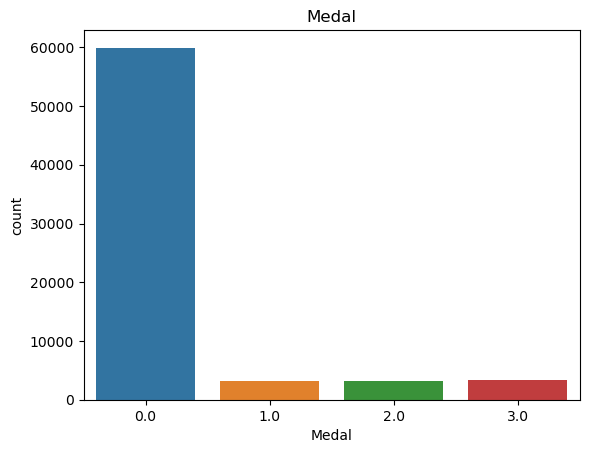

We can say also that women are better to win bronze and gold medals while the percentage of silver medals is nearly the same for both.

Text(0.5, 1.0, 'Percentage of medals got by each gender')

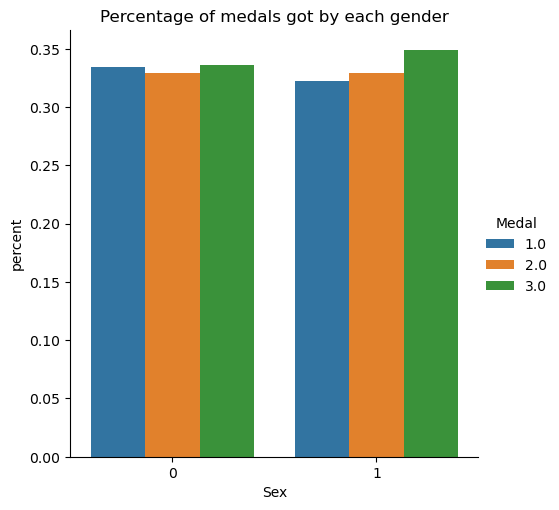

In [39]:
olympic_df_only_won_medals = olympic_df[olympic_df['Medal']>0]
x, y = 'Sex', 'Medal'
olympic_df_only_won_medals.groupby(x)[y].value_counts(normalize=True).rename('percent').reset_index()\
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar')
plt.title('Percentage of medals got by each gender')

Numbr of medals by sex

In [115]:
olympic_df_medals.dropna(subset=['Medal'], inplace=True)

In [116]:
olympic_df_medals['Medal'].unique()

array(['Gold', 'Bronze', 'Silver'], dtype=object)

In [127]:
sex_medal_count = olympic_df_medals.groupby(['Medal', 'Sex']).size()
sex_medal_count = sex_medal_count.unstack(fill_value=0)

In [128]:
sex_medal_count

Sex,F,M
Medal,,
Bronze,838,2370
Gold,906,2386
Silver,855,2335


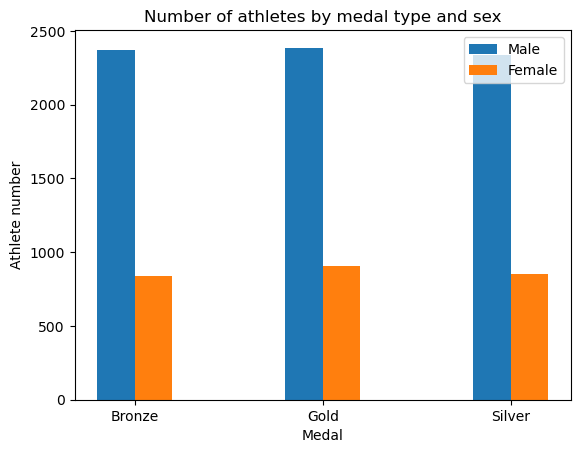

In [136]:
bar_width = 0.2
fig, ax = plt.subplots()
positions = range(len(sex_medal_count))

male_bar = ax.bar(positions, sex_medal_count['M'], width=bar_width, label='Male')
female_bar = ax.bar([p+bar_width for p in positions], sex_medal_count['F'], width=bar_width, label='Female')

ax.set_xlabel('Medal')
ax.set_ylabel('Athlete number')
ax.set_title('Number of athletes by medal type and sex')
ax.set_xticks([p + bar_width/2 for p in positions])
ax.set_xticklabels(sex_medal_count.index)
ax.legend()
plt.show()

### Medal distribution per age

In [97]:
len(olympic_df['Sport'].unique())

65

# MODEL 

# CONCLUSION